In [1]:
# Importing required libraries 
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

# **1. Data preparation and processing**

**Data preparation**

In [2]:
ref = pd.read_csv("./datasets/Data_path.csv")
ref.head()

labels source                         path
0  male_angry  SAVEE  ./datasets/SAVEE/DC/a01.wav
1  male_angry  SAVEE  ./datasets/SAVEE/DC/a02.wav
2  male_angry  SAVEE  ./datasets/SAVEE/DC/a03.wav
3  male_angry  SAVEE  ./datasets/SAVEE/DC/a04.wav
4  male_angry  SAVEE  ./datasets/SAVEE/DC/a05.wav

In [3]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 2 datasets 

df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                                        axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1
    print(counter, mfccs)

1 [-11.113933   -7.215756   -6.21919    -5.9265423  -5.850419   -4.8089604
  -2.5130029  -3.5005367  -3.721045   -4.4875593  -5.4290113  -7.3055735
  -7.1419296  -6.5555754  -4.5162992  -2.5563955  -2.2515771  -5.13335
  -5.566185   -7.20538    -7.9091716 -10.862606  -13.266886  -13.715888
 -15.576246   -8.864893   -5.8697057  -3.96915    -4.066767   -6.243663
  -5.814453   -7.329671   -8.715132   -8.864924  -10.491897  -11.772941
 -12.314169  -13.577661  -14.217988  -11.3124075  -9.449202   -9.782572
 -11.307087  -15.080504  -18.698631  -21.29243   -20.248941  -20.51274
 -20.142696  -19.977814  -19.676876  -21.12687   -21.941769  -22.895468
 -23.481457  -22.928883  -23.43159   -23.819021  -15.2186365  -7.6818385
  -4.474264   -3.4271357  -2.740891   -2.4472096  -3.4177973  -3.427022
  -3.8396382  -5.1096735  -6.422607   -7.8297963  -7.852357  -10.302065
 -11.0794115 -15.0834675 -16.734554  -20.405901  -23.169233  -20.038586
 -16.494411  -14.6714115 -14.88214   -13.396998   -9.339136  

In [4]:
# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1920


feature
0  [-11.113933, -7.215756, -6.21919, -5.9265423, ...
1  [-24.449831, -22.465742, -22.928043, -23.24380...
2  [-25.000114, -24.520256, -24.178183, -23.84745...
3  [-1.529839, -4.333437, -12.285238, -13.083024,...
4  [-22.458635, -22.467834, -25.884357, -27.82704...

In [5]:
# save it
df.to_pickle('./model/mfccs_1D')

In [6]:
# load it
df = pd.read_pickle('./model/mfccs_1D')
df.head()

feature
0  [-11.113933, -7.215756, -6.21919, -5.9265423, ...
1  [-24.449831, -22.465742, -22.928043, -23.24380...
2  [-25.000114, -24.520256, -24.178183, -23.84745...
3  [-1.529839, -4.333437, -12.285238, -13.083024,...
4  [-22.458635, -22.467834, -25.884357, -27.82704...

**Data processing**

In [7]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

labels source                         path          0          1  \
0  male_angry  SAVEE  ./datasets/SAVEE/DC/a01.wav -11.113933  -7.215756   
1  male_angry  SAVEE  ./datasets/SAVEE/DC/a02.wav -24.449831 -22.465742   
2  male_angry  SAVEE  ./datasets/SAVEE/DC/a03.wav -25.000114 -24.520256   
3  male_angry  SAVEE  ./datasets/SAVEE/DC/a04.wav  -1.529839  -4.333437   
4  male_angry  SAVEE  ./datasets/SAVEE/DC/a05.wav -22.458635 -22.467834   

           2          3          4          5          6  ...        206  \
0  -6.219190  -5.926542  -5.850419  -4.808960  -2.513003  ...  -4.088852   
1 -22.928043 -23.243807 -22.926605 -23.432241 -14.830004  ... -22.627258   
2 -24.178183 -23.847450 -15.182783 -10.732485  -8.681472  ...        NaN   
3 -12.285238 -13.083024 -12.041327 -11.819768  -9.414148  ...        NaN   
4 -25.884357 -27.827044 -27.593534 -26.666508 -18.659023  ... -25.291666   

         207        208        209        210        211        212  \
0  -5.023864  -5.254714  -5.234095  -5.310307  -5.621666  -6.072197   
1 -22.633406 -22.511597 -24.300154 -24.496809 -22.895985 -23.511503   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4 -25.854906 -26.821354 -25.436455 -24.179941 -23.281618 -24.167494   

         213        214        215  
0  -6.611348  -2.509089   1.964608  
1 -24.342152 -24.530262 -25.457796  
2        NaN        NaN        NaN  
3        NaN        NaN        NaN  
4 -25.228062 -25.902941 -25.589964  

[5 rows x 219 columns]

In [8]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(1920, 219)


labels source                         path          0          1  \
0  male_angry  SAVEE  ./datasets/SAVEE/DC/a01.wav -11.113933  -7.215756   
1  male_angry  SAVEE  ./datasets/SAVEE/DC/a02.wav -24.449831 -22.465742   
2  male_angry  SAVEE  ./datasets/SAVEE/DC/a03.wav -25.000114 -24.520256   
3  male_angry  SAVEE  ./datasets/SAVEE/DC/a04.wav  -1.529839  -4.333437   
4  male_angry  SAVEE  ./datasets/SAVEE/DC/a05.wav -22.458635 -22.467834   

           2          3          4          5          6  ...        206  \
0  -6.219190  -5.926542  -5.850419  -4.808960  -2.513003  ...  -4.088852   
1 -22.928043 -23.243807 -22.926605 -23.432241 -14.830004  ... -22.627258   
2 -24.178183 -23.847450 -15.182783 -10.732485  -8.681472  ...   0.000000   
3 -12.285238 -13.083024 -12.041327 -11.819768  -9.414148  ...   0.000000   
4 -25.884357 -27.827044 -27.593534 -26.666508 -18.659023  ... -25.291666   

         207        208        209        210        211        212  \
0  -5.023864  -5.254714  -5.234095  -5.310307  -5.621666  -6.072197   
1 -22.633406 -22.511597 -24.300154 -24.496809 -22.895985 -23.511503   
2   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4 -25.854906 -26.821354 -25.436455 -24.179941 -23.281618 -24.167494   

         213        214        215  
0  -6.611348  -2.509089   1.964608  
1 -24.342152 -24.530262 -25.457796  
2   0.000000   0.000000   0.000000  
3   0.000000   0.000000   0.000000  
4 -25.228062 -25.902941 -25.589964  

[5 rows x 219 columns]

In [9]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

In [10]:
# Lets see how the data present itself before normalisation 
X_train[150:160]

0          1          2          3          4          5    \
1196 -58.578617 -58.578617 -58.578617 -58.578617 -58.578617 -58.578617   
807  -49.203648 -43.896511 -42.766777 -42.542843 -43.345554 -44.991417   
845  -62.100266 -60.155819 -63.822628 -68.888374 -70.699570 -70.656204   
1912 -64.206718 -64.206718 -64.206718 -64.206718 -64.206718 -64.206718   
1588 -49.650131 -50.190395 -50.976841 -51.068001 -51.623962 -51.873104   
327   -6.926326  -4.573844  -5.084208  -7.231052  -8.401884 -10.942011   
1492 -55.564121 -53.010902 -51.636150 -52.978741 -54.883202 -55.698589   
1000 -43.894028 -44.508224 -46.965698 -49.532261 -46.516846 -45.775833   
1037 -42.172600 -42.172600 -42.146683 -42.172600 -42.172600 -41.897541   
1886 -60.209717 -61.792744 -57.893070 -54.121395 -51.305801 -47.766926   

            6          7          8          9    ...        206        207  \
1196 -58.578617 -58.578617 -58.433697 -55.639534  ... -43.742935 -43.844425   
807  -42.976730 -42.368595 -43.346909 -46.099037  ... -45.238991 -45.391239   
845  -70.740364 -70.853889 -70.261925 -69.039711  ... -45.796566 -46.854183   
1912 -64.206718 -64.206718 -64.206718 -64.206718  ... -56.091408 -59.251827   
1588 -52.943497 -53.552570 -51.887520 -51.598999  ... -43.604431 -44.173782   
327  -13.704258 -17.221737 -21.143187 -18.052040  ...  -8.848260  -9.740694   
1492 -54.186794 -52.699768 -49.874813 -49.402100  ... -53.626572 -53.897892   
1000 -45.254841 -45.293861 -45.870079 -47.802814  ... -41.834778 -44.185326   
1037 -41.546188 -41.409683 -41.293312 -41.251114  ... -37.148506 -36.890305   
1886 -47.981808 -48.230991 -48.983181 -49.097771  ... -38.770714 -40.692318   

            208        209        210        211        212        213  \
1196 -47.120911 -47.401226 -47.699448 -47.439919 -47.739780 -46.281387   
807  -47.429379 -46.739872 -47.317589 -49.158272 -49.950569 -49.553352   
845  -46.947327 -47.358177 -51.699253 -54.453613 -53.320599 -52.427788   
1912 -58.833820 -57.978340 -61.298141 -58.773544 -60.140408 -63.886536   
1588 -44.832890 -47.194767 -45.137016 -44.643780 -46.524578 -48.391464   
327  -11.600241 -14.486146 -15.132124 -16.173946 -17.497005 -12.059406   
1492 -54.915813 -52.078682 -50.838150 -51.630249 -50.695095 -51.499649   
1000 -43.440475 -43.414223 -45.300491 -45.732098 -43.943466 -44.085655   
1037 -38.127865 -39.780453 -40.361992 -40.608440 -42.482609 -41.637821   
1886 -37.988586 -37.762260 -39.635738 -39.829453 -37.223740 -36.612770   

            214        215  
1196 -46.539421 -49.180550  
807  -41.488201 -34.081284  
845  -50.584934 -51.101177  
1912 -63.014954 -63.745277  
1588 -47.425133 -45.681595  
327   -7.554891  -4.665598  
1492 -55.437229 -52.162704  
1000 -44.136963 -42.801540  
1037 -41.857754 -42.054775  
1886 -29.627529 -23.944246  

[10 rows x 216 columns]

In [11]:
# Let's do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

0         1         2         3         4         5         6    \
1196 -0.654425 -0.672461 -0.675871 -0.673249 -0.674119 -0.679185 -0.679819   
807  -0.117336  0.174364  0.254060  0.256549  0.195652  0.089227  0.192496   
845  -0.856179 -0.763430 -0.984284 -1.271037 -1.366196 -1.362222 -1.359793   
1912 -0.976857 -0.997075 -1.006873 -0.999581 -0.995470 -0.997477 -0.994491   
1588 -0.142915 -0.188650 -0.228793 -0.237763 -0.277025 -0.299960 -0.364755   
327   2.304715  2.442393  2.470261  2.304024  2.190850  2.014862  1.829145   
1492 -0.481725 -0.351330 -0.267569 -0.348552 -0.463120 -0.516307 -0.434269   
1000  0.186850  0.139082  0.007112 -0.148716  0.014579  0.044866  0.065125   
1037  0.285470  0.273795  0.290529  0.278017  0.262625  0.264199  0.272479   
1886 -0.747870 -0.857843 -0.635553 -0.414807 -0.258859 -0.067739 -0.087342   

           7         8         9    ...       206       207       208  \
1196 -0.678745 -0.674930 -0.523420  ... -0.311657 -0.307032 -0.481036   
807   0.221424  0.163231  0.005160  ... -0.396427 -0.394293 -0.498311   
845  -1.360411 -1.332059 -1.265840  ... -0.428020 -0.476822 -0.471314   
1912 -0.991283 -0.995656 -0.998074  ... -1.011346 -1.176212 -1.137002   
1588 -0.399640 -0.311251 -0.299559  ... -0.303809 -0.325613 -0.352898   
327   1.617870  1.396780  1.559068  ...  1.665545  1.616865  1.508252   
1492 -0.352283 -0.199433 -0.177842  ... -0.871684 -0.874180 -0.917579   
1000  0.058979  0.023053 -0.089236  ... -0.203537 -0.326264 -0.274918   
1037  0.274674  0.277320  0.273753  ...  0.061996  0.085271  0.022608   
1886 -0.104124 -0.149898 -0.160981  ... -0.029921 -0.129212  0.030408   

           209       210       211       212       213       214       215  
1196 -0.483198 -0.492247 -0.467166 -0.470457 -0.376859 -0.412650 -0.550609  
807  -0.446331 -0.471057 -0.562157 -0.591549 -0.554784 -0.149711  0.194213  
845  -0.480798 -0.714213 -0.854885 -0.776136 -0.711091 -0.623237 -0.645350  
1912 -1.072804 -1.246894 -1.093692 -1.149679 -1.334200 -1.270274 -1.269063  
1588 -0.471689 -0.350048 -0.312595 -0.403897 -0.491602 -0.458755 -0.378011  
327   1.351607  1.315045  1.261226  1.186036  1.484079  1.616668  1.645242  
1492 -0.743936 -0.666427 -0.698809 -0.632329 -0.660620 -0.875820 -0.697714  
1000 -0.260948 -0.359120 -0.372757 -0.262521 -0.257459 -0.287591 -0.235943  
1037 -0.058389 -0.085062 -0.089520 -0.182505 -0.124349 -0.168948 -0.199106  
1886  0.054113 -0.044760 -0.046457  0.105540  0.148905  0.467690  0.694257  

[10 rows x 216 columns]

In [12]:
# Convert the data format to a numpy array, because we are using keras

# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels_1D'
outfile = open('./model/'+filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1440, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [13]:
# Specify the 3rd dimension, which for us is 1. Its 1 because we're doing a 1D CNN and not a 2D CNN. 
# If we use the MFCC data in its entirity, we could feed that through as the input data, thus making the network a 2D CNN.

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1440, 216, 1)

# **2. Modeling**

In [14]:
# New model

model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))

opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                        

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
90/90 [==============================] - 12s 118ms/step - loss: 2.5517 - accuracy: 0.1208 - val_loss: 2.6329 - val_accuracy: 0.0688
Epoch 2/100
90/90 [==============================] - 11s 117ms/step - loss: 2.4249 - accuracy: 0.1667 - val_loss: 2.6220 - val_accuracy: 0.0688
Epoch 3/100
90/90 [==============================] - 11s 118ms/step - loss: 2.3465 - accuracy: 0.2056 - val_loss: 2.6051 - val_accuracy: 0.0750
Epoch 4/100
90/90 [==============================] - 11s 120ms/step - loss: 2.2868 - accuracy: 0.2326 - val_loss: 2.5743 - val_accuracy: 0.0896
Epoch 5/100
90/90 [==============================] - 11s 124ms/step - loss: 2.2371 - accuracy: 0.2361 - val_loss: 2.5223 - val_accuracy: 0.1208
Epoch 6/100
90/90 [==============================] - 11s 120ms/step - loss: 2.1909 - accuracy: 0.2569 - val_loss: 2.4340 - val_accuracy: 0.2062
Epoch 7/100
90/90 [==============================] - 11s 126ms/step - loss: 2.1442 - accuracy: 0.2812 - val_loss: 2.3315 - val_accuracy:

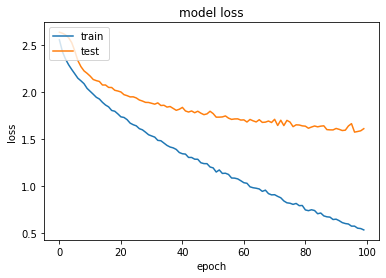

In [16]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **3. Model serialisation**

In [17]:
# Save model and weights
model_name = 'model_1D.h5'
save_dir = "./model/"

model_path = save_dir + model_name
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("./model/model_json_1D.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at ./model/model_1D.h5 


# **4. Model Validation**

In [18]:
# loading json and model architecture 
json_file = open('./model/model_json_1D.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./model/model_1D.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 43.33%


In [19]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

30/30 [==============================] - 1s 27ms/step


array([13,  4,  7,  7,  9,  0, 13,  9,  9,  5, 13, 11,  9,  1,  6,  1,  4,
        9, 11,  0,  6,  6, 12,  8,  8,  4,  8,  0,  9,  7,  4,  1,  5,  8,
       13,  7,  7, 10,  9, 11,  7,  4,  0,  6,  9, 12,  4,  4,  6,  1,  8,
       10, 13,  8, 11, 11, 10, 12,  9,  7,  4, 12, 10,  4,  9,  9,  9, 13,
        0, 11,  8,  8, 10,  0,  4, 10, 11, 12,  9,  9,  8, 13,  1,  1, 13,
        9, 11,  8,  2,  7,  4,  9,  6,  8, 10,  8,  2, 11,  7,  6, 11,  9,
        0,  8, 11, 13, 11, 11, 11,  6, 10, 11,  8, 10, 10,  9,  0,  4, 11,
        4,  4,  0, 11, 11,  9,  2,  6,  8, 10,  9, 12, 12, 11,  4, 10,  4,
       12,  1,  2,  7, 11,  9, 10,  8,  0,  2,  7, 10,  4,  9,  8,  4,  5,
       13,  1,  8,  7, 11, 11, 10,  7, 10, 12,  4,  3,  6,  9, 11, 13,  4,
        7, 10,  1, 10,  5,  4,  7,  5, 10,  6, 10, 12,  2, 11,  7,  9,  9,
       11, 11,  9,  9,  4,  4,  1,  9, 13,  9, 10,  7,  5, 10, 11,  2,  8,
       11, 11,  4,  4,  5,  9,  0,  8,  4,  5,  4, 10, 13, 13,  8, 10,  8,
       11,  4, 10,  4,  4

In [20]:
# The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure ..

# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

actualvalues  predictedvalues
170      male_angry       male_angry
171      male_happy       male_happy
172  female_disgust   female_disgust
173        male_sad       male_happy
174     female_fear       female_sad
175  female_neutral   female_neutral
176    male_disgust       male_angry
177  female_neutral       female_sad
178   male_surprise       male_happy
179    female_angry  female_surprise

In [21]:
# Write out the predictions to disk
finaldf.to_csv('./model/Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
female_angry               22
female_disgust             21
female_fear                12
female_happy               11
female_neutral             64
female_sad                 11
female_surprise            27
male_angry                 38
male_disgust               44
male_fear                  53
male_happy                 54
male_neutral               61
male_sad                   33
male_surprise              29

In [22]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

**Emotion by gender accuracy**

0.43333333333333335


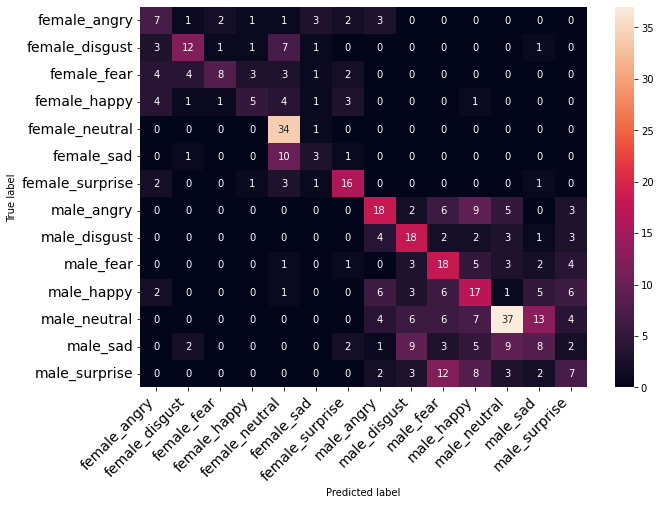

In [23]:
# Get the predictions file 
finaldf = pd.read_csv("./model/Predictions.csv")

classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [24]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.32      0.35      0.33        20
 female_disgust       0.57      0.46      0.51        26
    female_fear       0.67      0.32      0.43        25
   female_happy       0.45      0.25      0.32        20
 female_neutral       0.53      0.97      0.69        35
     female_sad       0.27      0.20      0.23        15
female_surprise       0.59      0.67      0.63        24
     male_angry       0.47      0.42      0.44        43
   male_disgust       0.41      0.55      0.47        33
      male_fear       0.34      0.49      0.40        37
     male_happy       0.31      0.36      0.34        47
   male_neutral       0.61      0.48      0.54        77
       male_sad       0.24      0.20      0.22        41
  male_surprise       0.24      0.19      0.21        37

       accuracy                           0.43       480
      macro avg       0.43      0.42      0.41       480
   weighted avg       0.44   

**Gender accuracy result**

0.96875


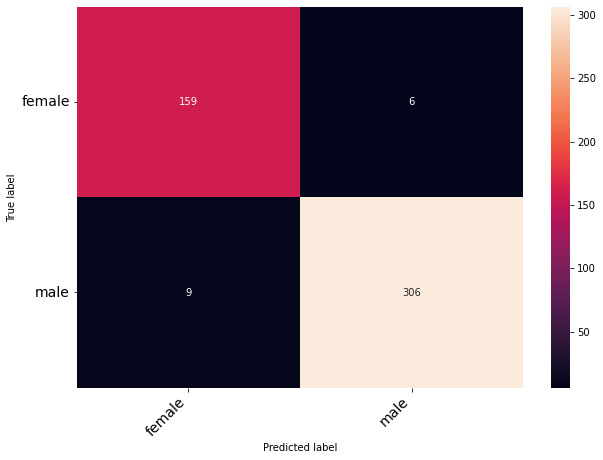

In [25]:
# if you notice, that the gender classification is more accurate. 
# So lets group them up and measure the accuracy again?

modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [26]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.95      0.96      0.95       165
        male       0.98      0.97      0.98       315

    accuracy                           0.97       480
   macro avg       0.96      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



**Emotion accuracy**

0.44166666666666665


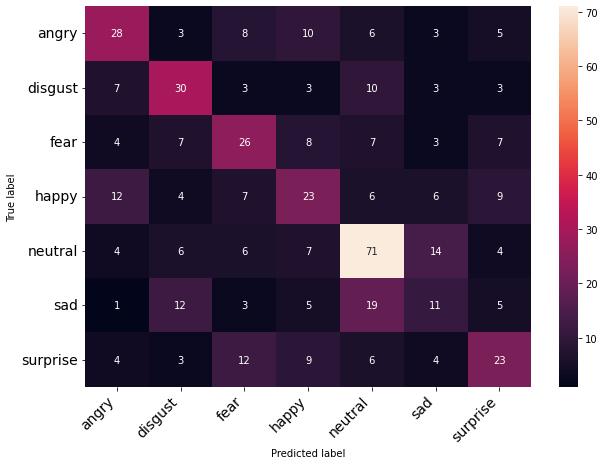

In [27]:
# We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get ..

modidf = pd.read_csv("./model/Predictions.csv")

modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [28]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.47      0.44      0.46        63
     disgust       0.46      0.51      0.48        59
        fear       0.40      0.42      0.41        62
       happy       0.35      0.34      0.35        67
     neutral       0.57      0.63      0.60       112
         sad       0.25      0.20      0.22        56
    surprise       0.41      0.38      0.39        61

    accuracy                           0.44       480
   macro avg       0.42      0.42      0.42       480
weighted avg       0.43      0.44      0.44       480

